# AutoEncoder Tutorial 

- https://blog.keras.io/building-autoencoders-in-keras.html


In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

## Define the AutoEncoder model (graph)

In [4]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(32, activation='relu')(input_img)
print(type(encoded))

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
print(type(decoded))

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Load MNIST dataset (and reshape)


In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


## Train the autoencoder

In [6]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [7]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(32,))
print(type(encoded_input))

<class 'tensorflow.python.framework.ops.Tensor'>


In [8]:
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
print(type(decoder_layer))

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

<class 'keras.layers.core.Dense'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


In [9]:
dir(autoencoder)
autoencoder.get_config().keys()

dict_keys(['name', 'layers', 'input_layers', 'output_layers'])

In [10]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
            epochs=4,
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 4s 72us/step - loss: 0.3670 - val_loss: 0.2716
Epoch 2/4
60000/60000 [==============================] - 4s 70us/step - loss: 0.2646 - val_loss: 0.2537
Epoch 3/4
60000/60000 [==============================] - 4s 67us/step - loss: 0.2434 - val_loss: 0.2309
Epoch 4/4
60000/60000 [==============================] - 4s 67us/step - loss: 0.2232 - val_loss: 0.2130


In [11]:
# Visualise 10 test examples, and the decoded versions
def visualize(x_test, decoded_imgs):
    n = 15  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

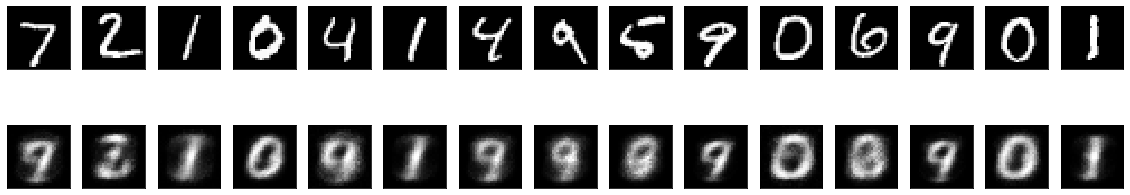

In [12]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualize(x_test, decoded_imgs)

## Use a regularizer to create sparse latent representation

In [13]:
from keras import regularizers
encoding_dim = 32
input_img = Input(shape=(784,))

######## new bit #######
# use a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(input_img)
######## new bit #######

######## same as before #######
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.3583 - val_loss: 0.2711
Epoch 2/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.2636 - val_loss: 0.2523
Epoch 3/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.2417 - val_loss: 0.2288
Epoch 4/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.2210 - val_loss: 0.2111
Epoch 5/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.2061 - val_loss: 0.1986


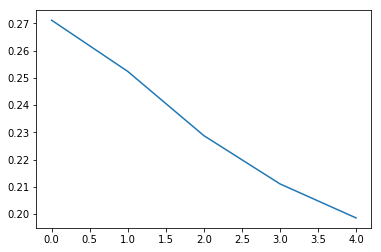

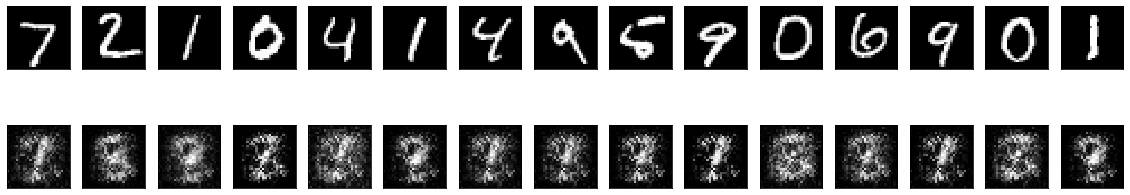

In [14]:
plt.plot(history.history['val_loss'])
ncoded_imgs = encoder.predict(x_test)
# encoded_imgs = np.random.normal(size=(encoded_imgs.shape))
decoded_imgs = decoder.predict(encoded_imgs)
visualize(x_test, decoded_imgs)

## Deep architecture

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 16s 260us/step - loss: 0.3339 - val_loss: 0.2650
Epoch 2/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.2568 - val_loss: 0.2515
Epoch 3/100
60000/60000 [==============================] - 16s 264us/step - loss: 0.2402 - val_loss: 0.2254
Epoch 4/100
60000/60000 [==============================] - 13s 215us/step - loss: 0.2141 - val_loss: 0.2030
Epoch 5/100
60000/60000 [==============================] - 11s 180us/step - loss: 0.1984 - val_loss: 0.1901
Epoch 6/100
60000/60000 [==============================] - 11s 190us/step - loss: 0.1866 - val_loss: 0.1815
Epoch 7/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.1797 - val_loss: 0.1753
Epoch 8/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1740 - val_loss: 0.1705
Epoch 9/100
60000/60000 [==============================] - 11s 186us/step - loss: 0.16

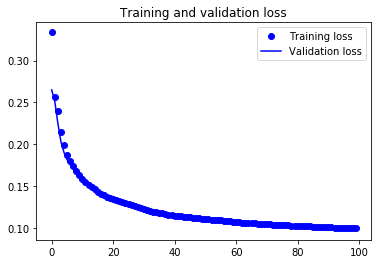

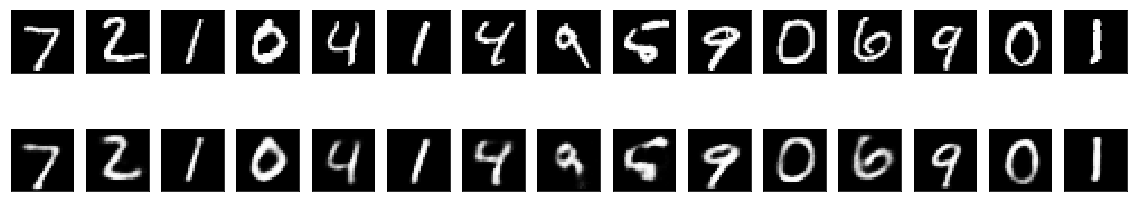

In [17]:
encoding_dim = 32
epochs = 100
def deep_autoencoder(input_img):
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    return decoded

input_img = Input(shape=(784,))
autoencoder = Model(input_img, deep_autoencoder(input_img))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

decoded_imgs = autoencoder.predict(x_test)
visualize(x_test, decoded_imgs)


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 283us/step - loss: 0.3183 - val_loss: 0.2632
Epoch 2/20
60000/60000 [==============================] - 19s 311us/step - loss: 0.2510 - val_loss: 0.2390
Epoch 3/20
60000/60000 [==============================] - 12s 204us/step - loss: 0.2299 - val_loss: 0.2215
Epoch 4/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.2155 - val_loss: 0.2073
Epoch 5/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.2016 - val_loss: 0.1938
Epoch 6/20
60000/60000 [==============================] - 14s 235us/step - loss: 0.1877 - val_loss: 0.1807
Epoch 7/20
60000/60000 [==============================] - 15s 247us/step - loss: 0.1797 - val_loss: 0.1766
Epoch 8/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.1743 - val_loss: 0.1694
Epoch 9/20
60000/60000 [==============================] - 20s 331us/step - loss: 0.1678 - val_

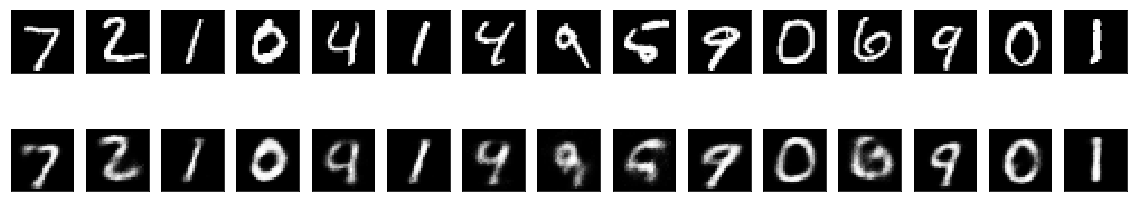

In [30]:
nepochs = 20
encoding_dim = 32
input_img = Input(shape=(784,))

def deep_autoencoder(input_img, encoding_dim=32):
    
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    
    # encoder model
    encoder = Model(input_img, encoded, name='enc')
    
    latent_dim = Input(shape=(encoding_dim,))
    decoded = Dense(64, activation='relu')(latent_dim)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    # decoder model
    decoder = Model(latent_dim, decoded, name='dec')
    
    # autoencoder model - need to link the two models
    autoencoder = Model(input_img, decoder(encoder(input_img)))
    return (autoencoder, encoder, decoder)

autoencoder, encoder, decoder = deep_autoencoder(input_img) 

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=nepochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualize(x_test, decoded_imgs)

## Try a different optimizer and loss function:

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 154us/step - loss: 0.0542 - val_loss: 0.0380
Epoch 2/20
60000/60000 [==============================] - 10s 172us/step - loss: 0.0342 - val_loss: 0.0308
Epoch 3/20
60000/60000 [==============================] - 16s 261us/step - loss: 0.0286 - val_loss: 0.0261
Epoch 4/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0252 - val_loss: 0.0229
Epoch 5/20
60000/60000 [==============================] - 10s 168us/step - loss: 0.0229 - val_loss: 0.0214
Epoch 6/20
60000/60000 [==============================] - 12s 208us/step - loss: 0.0212 - val_loss: 0.0213
Epoch 7/20
60000/60000 [==============================] - 13s 210us/step - loss: 0.0200 - val_loss: 0.0188
Epoch 8/20
60000/60000 [==============================] - 11s 182us/step - loss: 0.0190 - val_loss: 0.0175
Epoch 9/20
60000/60000 [==============================] - 11s 179us/step - loss: 0.0181 - val_l

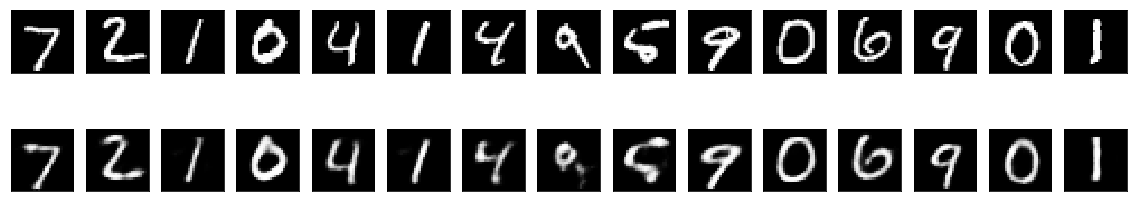

In [31]:
autoencoder, encoder, decoder = deep_autoencoder(input_img) 
autoencoder.compile(optimizer = RMSprop(), loss='mean_squared_error')
history = autoencoder.fit(x_train, x_train,
                epochs=nepochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualize(x_test, decoded_imgs)

## Convolutional autoencoder


In [ ]:

    latent_dim = Input(shape=(encoding_dim,))
    decoded = Dense(64, activation='relu')(latent_dim)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    # decoder model
    decoder = Model(latent_dim, decoded, name='dec')
    
    # autoencoder model - need to link the two models
    autoencoder = Model(input_img, decoder(encoder(input_img)))
    return (autoencoder, encoder, decoder)

In [61]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

def conv_autoencoder():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # encoder part of the model
    encoder = Model(input_img, encoded, name='enc')

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    lat_dim = Input(shape=(4, 4, 8))

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(lat_dim)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # decoder part of the model
    decoder = Model(lat_dim, decoded, name='dec')

    autoencoder = Model(input_img, decoder(encoder(input_img)))
    return (autoencoder, encoder, decoder)

In [62]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


In [68]:
from keras.callbacks import TensorBoard
nepochs = 5
autoencoder, encoder, decoder = conv_autoencoder()
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer = RMSprop(), loss='mean_squared_error')

history = autoencoder.fit(x_train, x_train,
                epochs=nepochs,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

/home/scpd/Software/anaconda3/envs/env3.5/lib/python3.5/site-packages/keras/callbacks.py:694: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 224s 4ms/step - loss: 0.0355 - val_loss: 0.0256
Epoch 2/5
60000/60000 [==============================] - 245s 4ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 3/5
60000/60000 [==============================] - 251s 4ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 4/5
60000/60000 [==============================] - 212s 4ms/step - loss: 0.0174 - val_loss: 0.0161
Epoch 5/5
60000/60000 [==============================] - 223s 4ms/step - loss: 0.0163 - val_loss: 0.0148


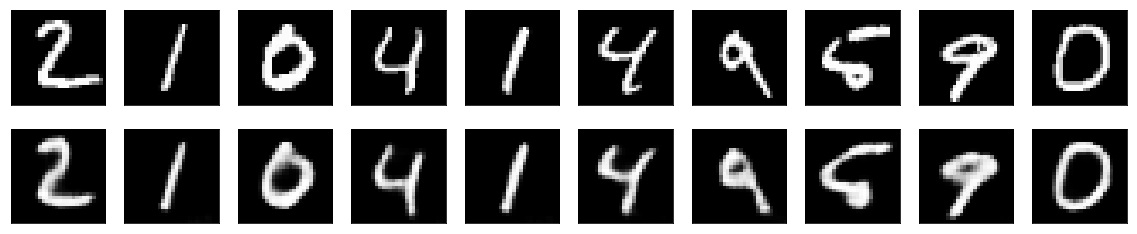

In [69]:
n = 10
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(20, 4))
for i in range(n):
    i+=1
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.


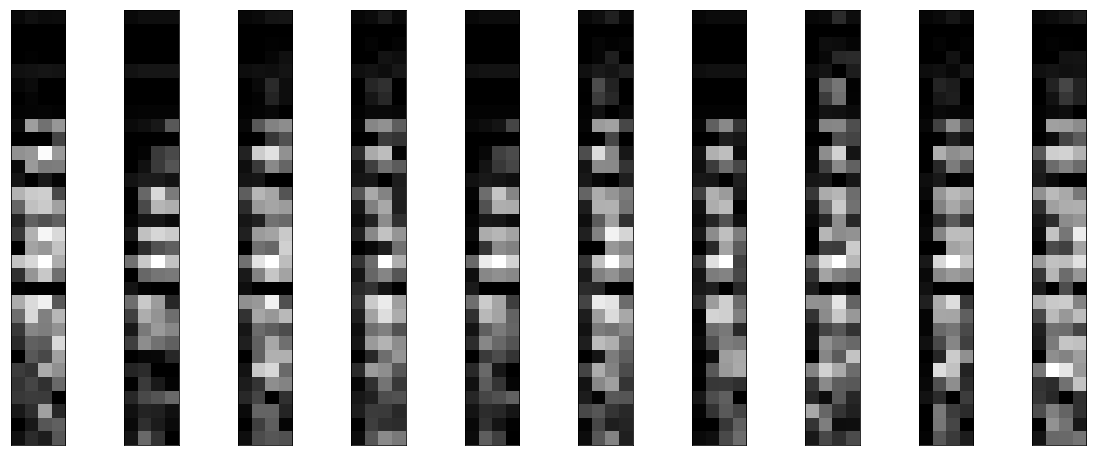

In [71]:
encoded_imgs = encoder.predict(x_test)
plt.figure(figsize=(20, 8))
for i in range(n):
    i+=1
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()